In [482]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [483]:
data = pd.read_csv('cleaned_dft_statistics_collision_and_casualty_last_5_years.csv', low_memory = False)
data = data.copy()

pd.options.mode.chained_assignment = None

# Exploratory data analysis

We want to investigate which features correlate with accident severity. Who, what, when, or where influences accident severity?

First up, let's seperate our training and test data to prevent any data leakage. We need to be a little bit clever here, as accidents with multiple casualties have multiple entries. We need to make sure that the duplicate accident_index entries are not split between the train and test sets, as this would be quie a severe leakage of information.

To do this, let's make a dummy dataframe with only the unique accident_indexes, split between test and train as normal, and then append the duplicate crash entries to the appropriate set (train or test.)

We should also be aware that we have unbalanced classes in the casualty_severity predictor, so we should stratify our split.

In [484]:
np.round(data.casualty_severity.value_counts() / data.shape[0] * 100)

casualty_severity
Slight     73.0
Serious    25.0
Fatal       1.0
Name: count, dtype: float64

In [485]:
data_no_dup = data.groupby('accident_index').first().reset_index()

train_no_dup, test_no_dup = train_test_split(data_no_dup, test_size=0.2, random_state=0, stratify=data_no_dup.casualty_severity)

train = train_no_dup.merge(data, on='accident_index', how='left', suffixes=('', '_remove'))
test = test_no_dup.merge(data, on='accident_index', how='left', suffixes=('', '_remove'))

# remove the duplicate columns
train.drop([i for i in train.columns if 'remove' in i], axis=1, inplace=True)
test.drop([i for i in test.columns if 'remove' in i], axis=1, inplace=True)

dup_check = train.merge(test, on='accident_index', how='inner')
print(dup_check.shape[0])

0


There we go, a fully stratified train and test split with no crossover of the accidents.

Now we can poke around and get to know our data a little better. 

In [486]:
train.describe()

,number_of_vehicles,number_of_casualties,time,speed_limit,age_of_casualty,Year,Month,Day
count,11669.000000,11669.000000,11669.000000,11669.000000,11669.000000,11669.000000,11669.000000,11669.000000
mean,1.951667,1.789442,13.813694,37.974976,36.282972,2019.887223,6.642129,15.805382
std,0.758719,1.397009,5.272770,13.415797,19.232674,1.429931,3.490591,8.793487
min,1.000000,1.000000,0.000000,20.000000,-1.000000,2018.000000,1.000000,1.000000
25%,2.000000,1.000000,10.000000,30.000000,22.000000,2019.000000,4.000000,8.000000
50%,2.000000,1.000000,14.000000,30.000000,33.000000,2020.000000,7.000000,16.000000
75%,2.000000,2.000000,18.000000,40.000000,50.000000,2021.000000,10.000000,23.000000
max,8.000000,17.000000,23.000000,70.000000,98.000000,2022.000000,12.000000,31.000000


Some interesting observations off the bat:

* 50 % of the crashes involve 2 vehicles. There are some outliers, involving up to 8 vehicles.
* This is similar for our number of casualties. For the most part, 1 or 2 casualties are reported, but an outlier involved 17 casualties is included - this is likely the 8 vehicle incident. 
* Half of our crashes are hapenning between 30 and 40 mph. A mean value of approximately 38 mph show this is skewed towards the higher value. We again see some outlier values up to 70 mph - as you would expect from UK motorway incidents.
* No crashes are reported for areas with speed limits below 20 mph. 
* We are clearly missing some age values, as values of -1 indicate missing data here. We should test the correlation between age and crash severity. If this is an important predictor and we can't infill the data, we might want to drop these rows.
* The missing data (-1s) might be skewing the mean, but on average the casualties are in their mid-thirties. The IQR spans from 22 to 50, with some casualties as old as 98.
* Although these features are numerical datatypes, only age_of_casualty is a continuous variable.

In [487]:
pd.set_option('display.max_columns', None)
train.describe(exclude=[np.number])

,accident_index,accident_severity,day_of_week,local_authority_district,local_authority_highway,first_road_class,road_type,junction_detail,second_road_class,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,trunk_road_flag,lsoa_of_accident_location,casualty_class,sex_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,geometry
count,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669,11669
unique,8775,3,7,4,4,6,6,9,7,4,7,5,9,6,2,2,822,3,3,12,3,10,10,4,6,4,21,4,11,8736
top,2020140924772,Slight,Friday,Sheffield,E08000019,Unclassified,Single carriageway,Not at junction or within 20 metres,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,Urban,Non-trunk,E01033269,Driver or rider,Male,26 - 35,Slight,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Car occupant,Urban area,Data missing or out of range,POINT (-1.386526 53.371086)
freq,17,7682,1979,4288,4288,5170,8460,5390,5389,11483,10023,7978,9030,8044,8111,10732,193,8327,7056,2474,8458,9974,9974,10336,11474,11512,7277,7432,2815,17


Whew, lot's of information here. Let's dig in.

* 

In [488]:
numerical_feats = train.describe().columns
categorical_feats = train.describe(exclude=[np.number]).columns

### Time to explore the relationship of our features with the accident_severity

Who is involved in the most severe crashes? When do they occur? Where do they occur?

### Who?

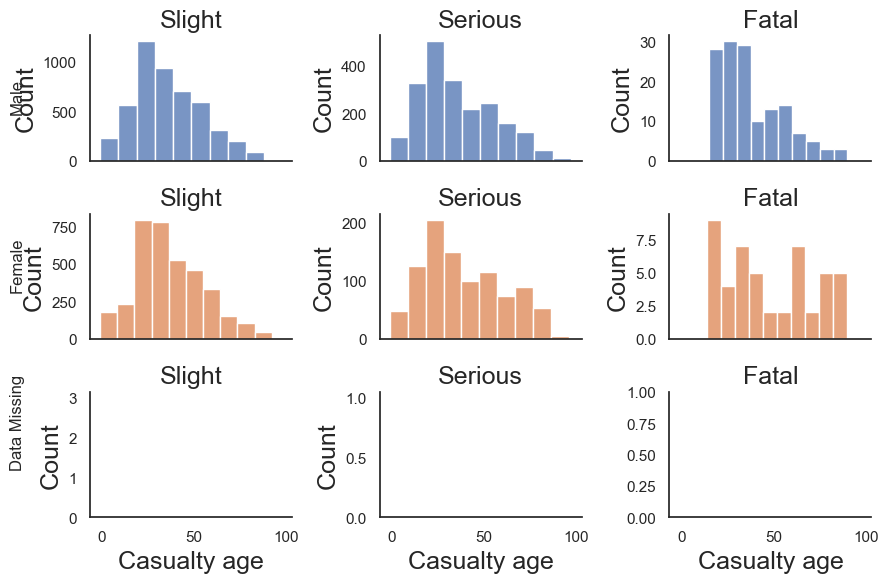

In [489]:
sns.set_style('white')
g = sns.FacetGrid(train, col='casualty_severity', row='sex_of_casualty', sharey=False, hue='sex_of_casualty', height=2, aspect=1.5)
g.map(sns.histplot, 'age_of_casualty', bins=10)
g.set_titles('{col_name}', '{row_name}')
g.set_xlabels(label = 'Casualty age')
labels = ['Male', 'Female', 'Data Missing']
for ind,ax in enumerate(g.axes):
  ax[0].annotate(labels[ind], (-80, 50), xycoords = 'axes pixels', rotation=90)

In [490]:
table = pd.pivot_table(train, index=['casualty_class'], columns='casualty_severity', values='accident_index', aggfunc=len)
table / train.shape[0]*100

casualty_severity,Fatal,Serious,Slight
casualty_class,,,
Driver or rider,1.011226,17.147999,53.200788
Passenger,0.154255,3.325049,10.635016
Pedestrian,0.462765,5.416060,8.646842


In [491]:
table = pd.pivot_table(train, index=['casualty_type'], columns='casualty_severity', values='accident_index', aggfunc=len)
table / train.shape[0]*100

casualty_severity,Fatal,Serious,Slight
casualty_type,,,
Agricultural vehicle occupant,NaN,0.034279,0.094267
Bus or coach occupant (17 or more pass seats),NaN,0.359928,1.645385
Car occupant,0.805553,12.623190,48.933071
Cyclist,0.025709,2.913703,5.707430
Electric motorcycle rider or passenger,NaN,0.059988,0.025709
Goods vehicle (7.5 tonnes mgw and over) occupant,0.042849,0.068558,0.248522
Goods vehicle (over 3.5t. and under 7.5t.) occupant,NaN,0.051418,0.042849
Goods vehicle (unknown weight) occupant,NaN,0.085697,0.274231
Horse rider,NaN,NaN,0.059988


In [492]:
table = pd.pivot_table(train, index=['number_of_casualties'], columns='casualty_severity', values='accident_index', aggfunc=len)
np.round(table / train.shape[0]*100, 2)

casualty_severity,Fatal,Serious,Slight
number_of_casualties,,,
1,0.80,16.88,40.88
2,0.36,4.76,18.41
3,0.21,1.98,6.94
4,0.21,1.06,3.05
5,NaN,0.60,1.46
6,NaN,0.41,0.77
7,0.06,0.12,0.36
8,NaN,0.07,0.21
9,NaN,NaN,0.15


In [493]:
table = pd.pivot_table(train, index=['number_of_vehicles'], columns='casualty_severity', values='accident_index', aggfunc=len)
np.round(table / train.shape[0]*100, 2)

casualty_severity,Fatal,Serious,Slight
number_of_vehicles,,,
1,0.78,8.56,14.14
2,0.46,14.55,47.97
3,0.19,2.13,7.88
4,0.08,0.48,1.66
5,0.09,0.10,0.49
6,0.03,0.05,0.22
7,NaN,0.01,0.05
8,NaN,0.01,0.07


In [494]:
train.pedestrian_location.value_counts(normalize=True)

pedestrian_location
Not a Pedestrian                                                           0.854743
In carriageway, crossing elsewhere                                         0.062987
Unknown or other                                                           0.019368
In carriageway, not crossing                                               0.017654
Crossing on pedestrian crossing facility                                   0.017568
On footway or verge                                                        0.015511
In centre of carriageway - not on refuge, island or central reservation    0.006941
Crossing elsewhere within 50m. of pedestrian crossing                      0.004199
On refuge, central island or central reservation                           0.000857
Crossing in zig-zag approach lines                                         0.000171
Name: proportion, dtype: float64

In [495]:
train.pedestrian_movement.value_counts(normalize=True)

pedestrian_movement
Not a Pedestrian                                                                                             0.854743
Unknown or other                                                                                             0.068472
Crossing from driver's nearside                                                                              0.034793
Crossing from driver's offside                                                                               0.017654
In carriageway, stationary - not crossing  (standing or playing)                                             0.009512
Crossing from nearside - masked by parked or stationary vehicle                                              0.004799
Walking along in carriageway, facing traffic                                                                 0.003771
Crossing from offside - masked by  parked or stationary vehicle                                              0.002657
Walking along in carriageway, back t

In [496]:
train.car_passenger.value_counts(normalize=True)

car_passenger
Not car passenger               0.885766
Front seat passenger            0.073185
Rear seat passenger             0.039849
Data missing or out of range    0.001200
Name: proportion, dtype: float64

In [497]:
train.bus_or_coach_passenger.value_counts(normalize=True)

bus_or_coach_passenger
Not a bus or coach passenger    0.983289
Seated passenger                0.010455
Standing passenger              0.002828
Data missing or out of range    0.001200
Alighting                       0.001114
Boarding                        0.001114
Name: proportion, dtype: float64

In [498]:
train.pedestrian_road_maintenance_worker.value_counts(normalize=True)

pedestrian_road_maintenance_worker
No / Not applicable             0.986546
Not Known                       0.011912
Data missing or out of range    0.000771
Yes                             0.000771
Name: proportion, dtype: float64

In [499]:
train.casualty_home_area_type.value_counts(normalize=True)

casualty_home_area_type
Urban area                      0.636901
Data missing or out of range    0.240809
Small town                      0.077556
Rural                           0.044734
Name: proportion, dtype: float64

In [500]:
train.casualty_imd_decile.value_counts(normalize=True)

casualty_imd_decile
Data missing or out of range    0.241237
Most deprived 10%               0.162739
More deprived 10-20%            0.113977
More deprived 20-30%            0.104808
More deprived 30-40%            0.077727
Less deprived 40-50%            0.065216
More deprived 40-50%            0.057160
Less deprived 30-40%            0.055275
Less deprived 20-30%            0.049876
Less deprived 10-20%            0.047476
Least deprived 10%              0.024509
Name: proportion, dtype: float64

In [501]:
train[train.casualty_imd_decile.isin(['Data missing or out of range'])]

,accident_index,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,local_authority_district,local_authority_highway,first_road_class,road_type,speed_limit,junction_detail,second_road_class,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,trunk_road_flag,lsoa_of_accident_location,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,Year,Month,Day,geometry
5,2018140295128,Serious,2,1,Friday,18,Sheffield,E08000019,A,Dual carriageway,30,Not at junction or within 20 metres,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,Urban,Non-trunk,E01033268,Driver or rider,Female,29,26 - 35,Serious,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Car occupant,Data missing or out of range,Data missing or out of range,2018,5,11,POINT (-1.462044 53.379935)
7,2019140870577,Slight,4,1,Sunday,16,Rotherham,E08000018,A,Single carriageway,40,Not at junction or within 20 metres,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,Urban,Non-trunk,E01007717,Driver or rider,Female,50,46 - 55,Slight,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Taxi/Private hire car occupant,Data missing or out of range,Data missing or out of range,2019,8,4,POINT (-1.381422 53.432992)
16,2018140811180,Slight,2,1,Friday,9,Sheffield,E08000019,B,Single carriageway,30,T or staggered junction,Unclassified,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,Urban,Non-trunk,E01007855,Driver or rider,Male,18,16 - 20,Slight,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Motorcycle - unknown cc rider or passenger,Data missing or out of range,Data missing or out of range,2018,10,19,POINT (-1.427005 53.410001)
20,2019140882005,Slight,2,1,Friday,9,Sheffield,E08000019,B,Single carriageway,30,T or staggered junction,B,None within 50 metres,Zebra,Daylight,Fine no high winds,Dry,Urban,Non-trunk,E01008109,Driver or rider,Female,51,46 - 55,Slight,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Car occupant,Data missing or out of range,Data missing or out of range,2019,9,27,POINT (-1.474882 53.366455)
21,2019140825623,Slight,2,1,Friday,17,Sheffield,E08000019,A,Dual carriageway,30,Not at junction or within 20 metres,Not at junction or within 20 metres,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,Urban,Non-trunk,E01033272,Driver or rider,Male,29,26 - 35,Slight,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Cyclist,Data missing or out of range,Data missing or out of range,2019,3,22,POINT (-1.483354 53.372964)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11652,2018140809418,Slight,2,1,Monday,10,Sheffield,E08000019,Unclassified,Single carriageway,30,Crossroads,A,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Dry,Urban,Non-trunk,E01008161,Driver or rider,Male,32,26 - 35,Slight,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Car occupant,Data missing or out of range,Data missing or out of range,2018,12,24,POINT (-1.501136 53.402576)
11655,2019140825819,Slight,2,1,Thursday,21,Sheffield,E08000019,B,Single carriage

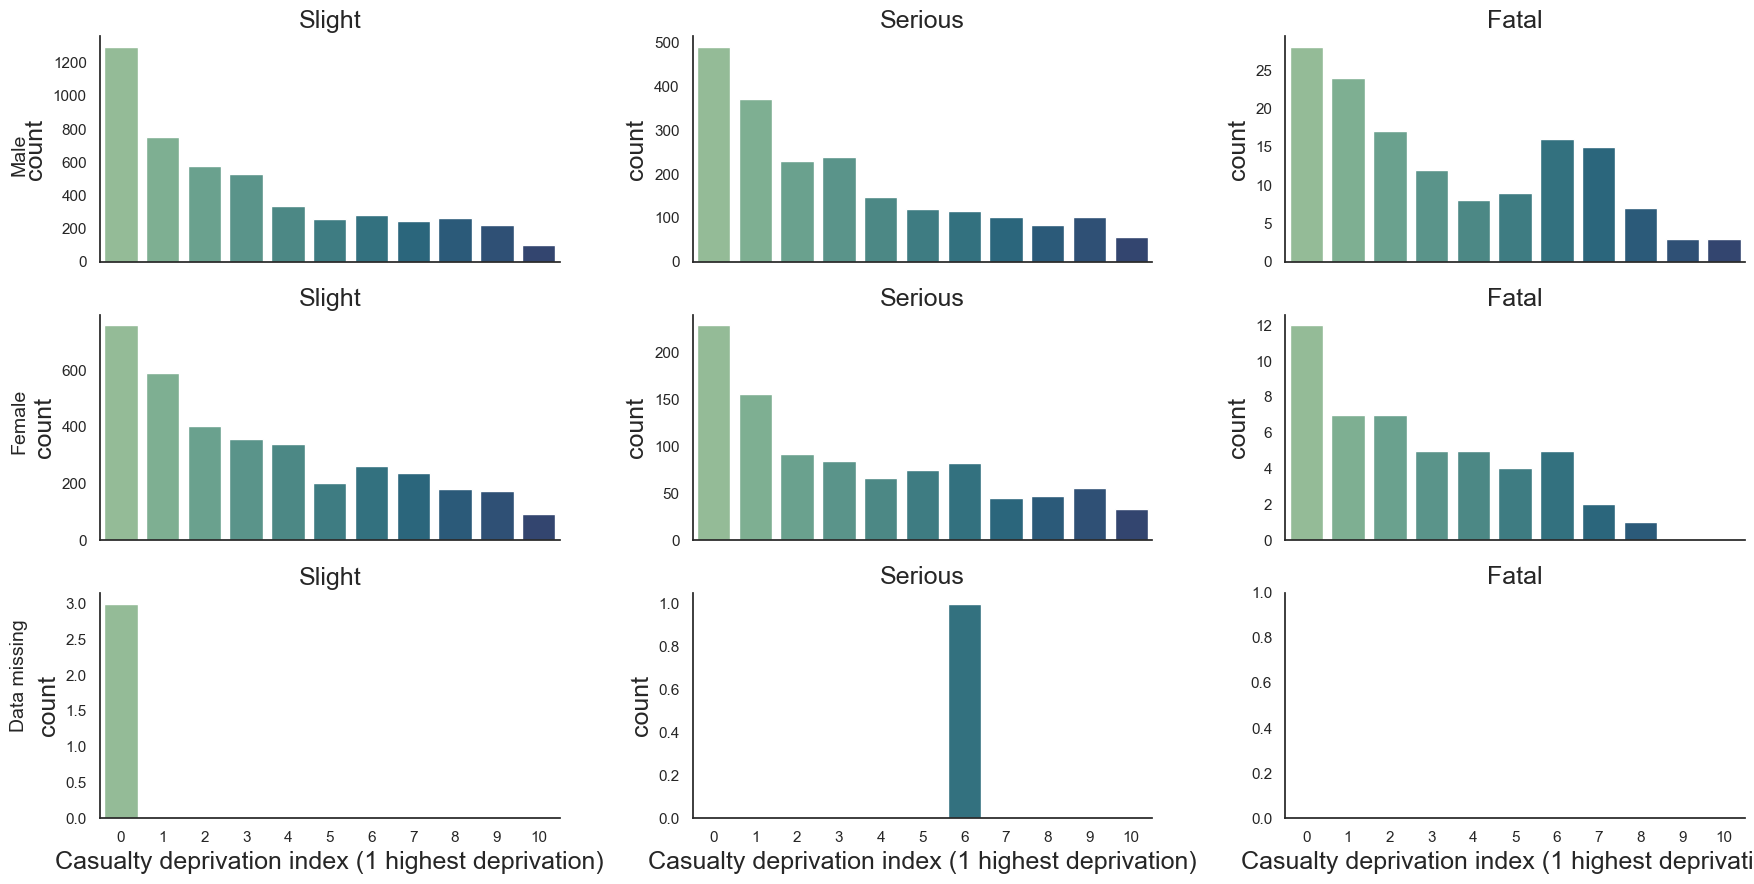

In [502]:
order = ['Data missing or out of range', 'Most deprived 10%', 'More deprived 10-20%', 'More deprived 20-30%', 'More deprived 30-40%', 'More deprived 40-50%', 'Less deprived 40-50%', 'Less deprived 30-40%', 'Less deprived 20-30%', 'Less deprived 10-20%', 'Least deprived 10%']
sns.set_style('white')
g = sns.FacetGrid(train, col='casualty_severity', row='sex_of_casualty', sharey=False, aspect=2)
g.map(sns.countplot, 'casualty_imd_decile', order=order, palette='crest')
g.set_titles('{col_name}', '{row_name}')
g.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
g.set_xlabels(label = 'Casualty deprivation index (1 highest deprivation)')
labels = ['Male', 'Female', 'Data missing']
for ind,ax in enumerate(g.axes):
  ax[0].annotate(labels[ind], (-90, 90), xycoords = 'axes pixels', rotation=90, fontsize=14)

* Casualty_type and casualty_class could be combined for more granular information abou the casualties.

* The most fatal accidents occur (almost twice that of other categories) when there is a single car and a single casualty. Is this when a car is hitting a pedestrian/cyclist? Is it the driver of a single occupancy vehicle hitting a stationary object? We could potentially engineer a feature to encapsulate the nature of these single casualty/single vehicle incidents.

* The most serious injuries occur when 2 vehicles are involved.

* Age and gender of the casualties are clearly quite relevant to the frequency/outcome of crashes. There are a few entries that are missing this data, and with no way to infill, so we might want to drop those rows.

* casualty_imd_decile is quite strongly correlated with the frequency of accidents at all crash severities. The missing data (24 %) appears to be missing completely at random, so we could try random sample imputation to infill these values and include this feature in our model.

### When do the most severe accidents occur?

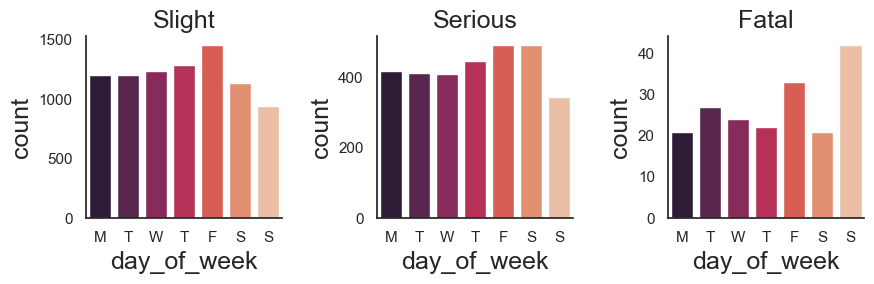

In [503]:
g = sns.FacetGrid(train, col='casualty_severity', sharey=False)
g.map(sns.countplot, 'day_of_week', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='rocket')
g.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'])
g.set_titles('{col_name}')


c:\Users\Elena\.conda\envs\DfT_project_env\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


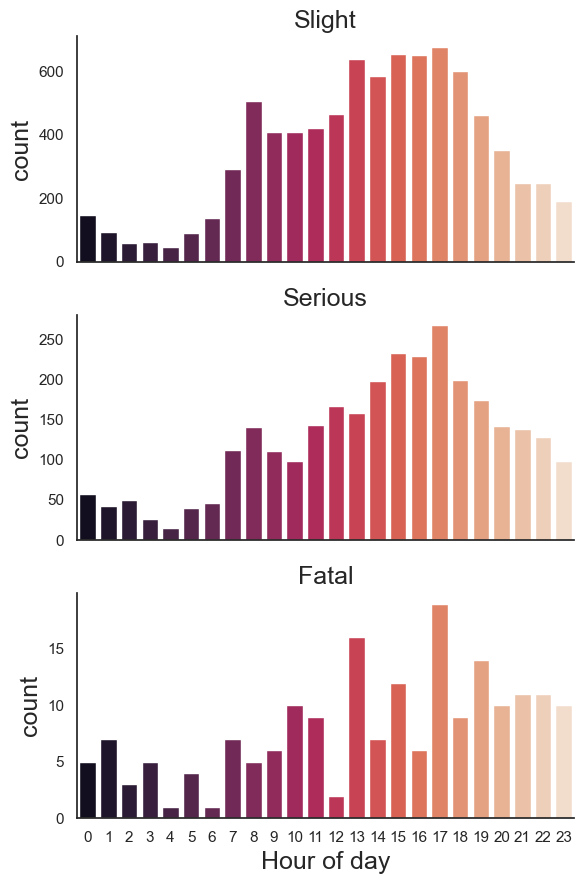

In [504]:
g = sns.FacetGrid(train, row='casualty_severity', sharey=False, aspect=2)
g.map(sns.countplot, 'time', palette='rocket', )
g.set_titles('{row_name}')
g.set_xlabels('Hour of day')

<Axes: xlabel='Year', ylabel='Month'>

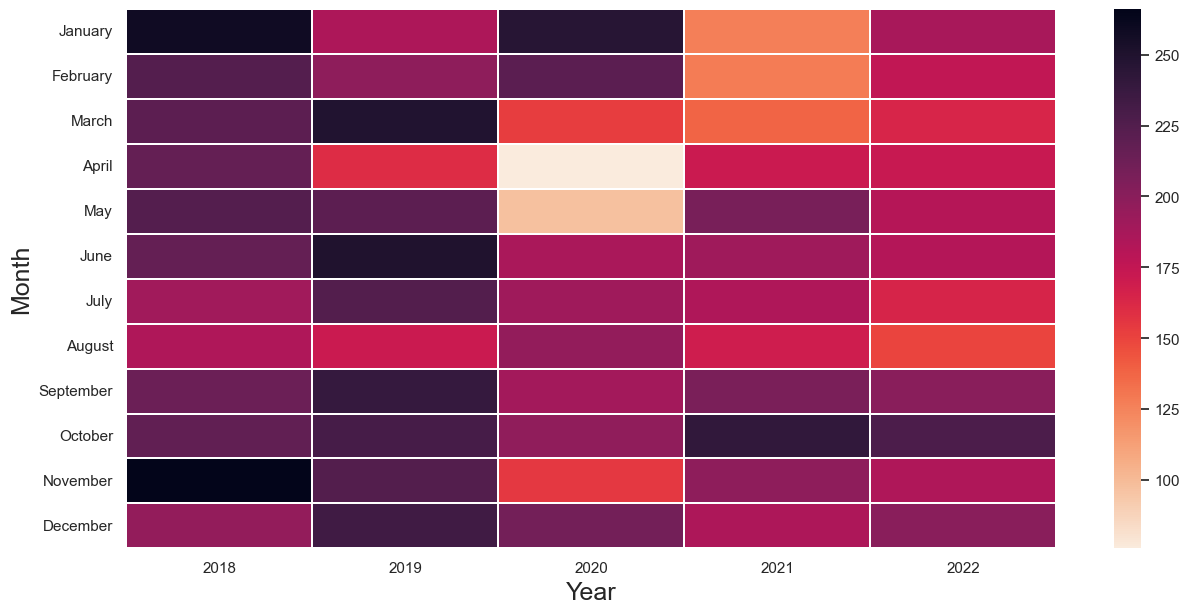

In [505]:
table = pd.pivot_table(train, values='accident_index', index='Month', columns='Year', aggfunc=len)
plt.figure(figsize=(15,7))
sns.set(rc={"axes.labelsize":18},font_scale=1)
sns.heatmap(table, yticklabels=yticks,linewidths=.1,annot=False,cmap='rocket_r')

### Where do the accidents occur, and where are they most severe?

In [506]:
district_data = train.groupby(['local_authority_district', 'casualty_severity']).size().reset_index().pivot(columns='casualty_severity', index='local_authority_district', values=0) / train.shape[0]*100
np.round(district_data, 1)

casualty_severity,Fatal,Serious,Slight
local_authority_district,,,
Barnsley,0.4,4.2,12.6
Doncaster,0.3,6.7,20.0
Rotherham,0.5,5.2,13.3
Sheffield,0.4,9.7,26.6


c:\Users\Elena\.conda\envs\DfT_project_env\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


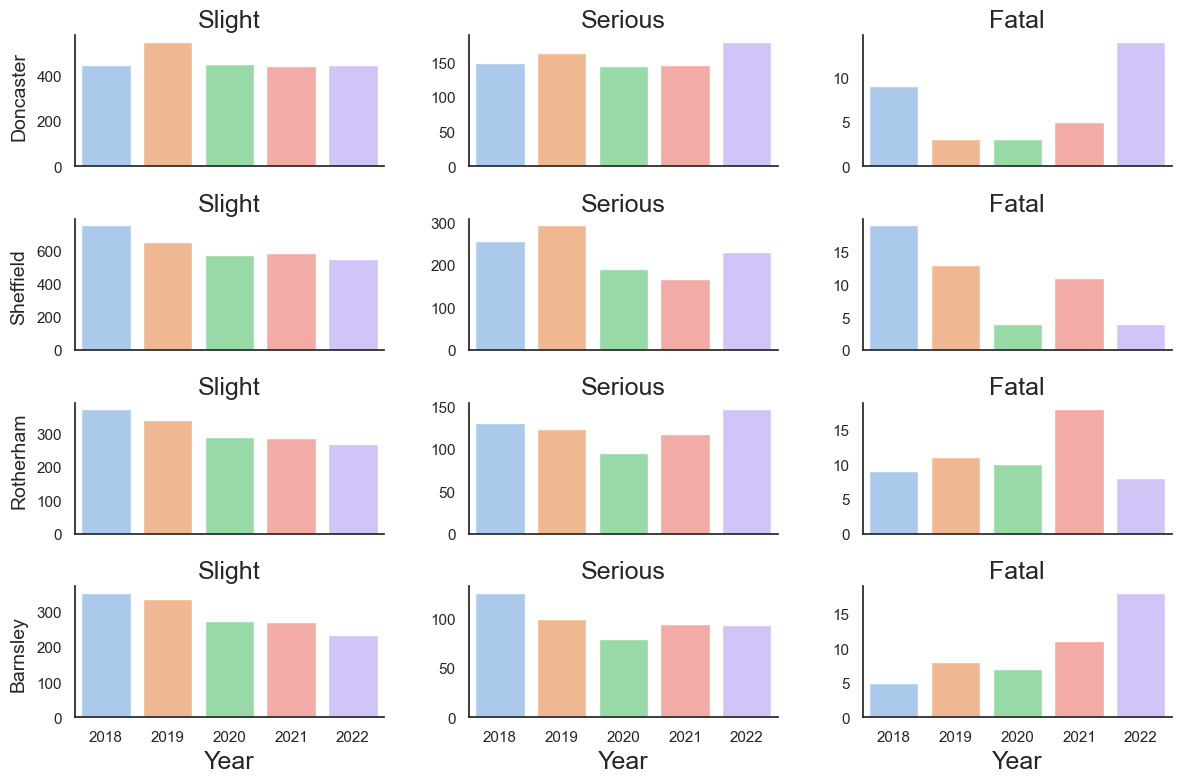

In [507]:
sns.set_style('white')
g = sns.FacetGrid(train,row='local_authority_district', col='casualty_severity', sharey=False, height=2, aspect=2,)
g.map(sns.countplot, 'Year', palette='pastel')
g.set_titles('{col_name}')
g.set_ylabels('')
labels = ['Doncaster', 'Sheffield', 'Rotherham', 'Barnsley']
for ind,ax in enumerate(g.axes):
  ax[0].annotate(labels[ind], (-65, 30), xycoords = 'axes pixels', rotation=90, fontsize=14)

c:\Users\Elena\.conda\envs\DfT_project_env\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


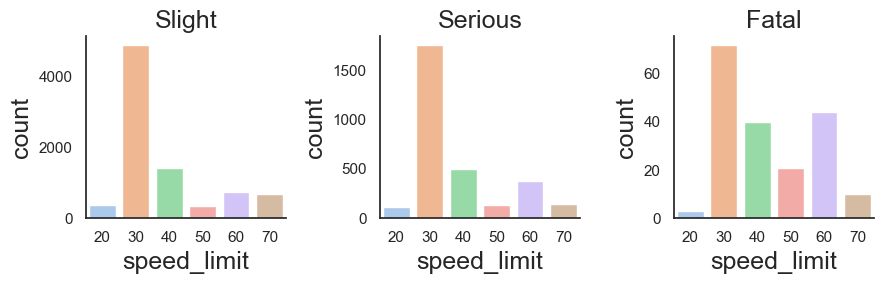

In [508]:
train.groupby(['speed_limit', 'casualty_severity']).size().reset_index().pivot(columns='casualty_severity', index='speed_limit', values=0) / train.shape[0]*100

sns.set_style('white')
g = sns.FacetGrid(train, col='casualty_severity', sharey=False)
g.map(sns.countplot, 'speed_limit', palette='pastel')
g.set_titles('{col_name}')

In [509]:
np.round(train.groupby(['urban_or_rural_area', 'casualty_severity']).size().reset_index().pivot(columns='casualty_severity', index='urban_or_rural_area', values=0) / train.shape[0]*100, 2)


casualty_severity,Fatal,Serious,Slight
urban_or_rural_area,,,
Rural,0.82,8.14,21.53
Urban,0.81,17.75,50.96


In [510]:
train.trunk_road_flag.value_counts(normalize=True)

trunk_road_flag
Non-trunk                                    0.919702
Trunk (Roads managed by Highways England)    0.080298
Name: proportion, dtype: float64

In [511]:
train.first_road_class.value_counts(normalize=True)

first_road_class
Unclassified    0.443054
A               0.363356
B               0.122033
Motorway        0.052618
A(M)            0.014311
C               0.004628
Name: proportion, dtype: float64

In [512]:
train.second_road_class.value_counts(normalize=True)


second_road_class
Not at junction or within 20 metres    0.461822
Unclassified                           0.398492
A                                      0.087154
B                                      0.044563
Motorway                               0.003856
C                                      0.003171
A(M)                                   0.000943
Name: proportion, dtype: float64

In [513]:
train.road_type.value_counts(normalize=True)


road_type
Single carriageway    0.724998
Dual carriageway      0.199931
Roundabout            0.051333
Slip road             0.012769
Unknown               0.005570
One way street        0.005399
Name: proportion, dtype: float64

In [514]:
train.junction_detail.value_counts(normalize=True)


junction_detail
Not at junction or within 20 metres    0.461908
T or staggered junction                0.248950
Crossroads                             0.113463
Other junction                         0.072071
Roundabout                             0.067615
More than 4 arms (not roundabout)      0.012083
Slip road                              0.009855
Private drive or entrance              0.007970
Mini-roundabout                        0.006084
Name: proportion, dtype: float64

* Over 90 % of the trunk road flag information is unclassified, so we can likely drop this column.
* Road_type and junction_detail contain very similar information. Speed_limit likely encapsulates similar data as the road_type, seeing as the road type determines the speed limit of a road. This also applies to the *road_class columns (first_ and second_). Junction_detail might be interesting, but we likely want to reduce the number of categories as some are quite infrequent.

### What are the road conditions when crashes occur?

In [515]:
print(train.light_conditions.value_counts(dropna=False))
np.round(train.groupby(['light_conditions', 'casualty_severity']).size().reset_index().pivot(columns='casualty_severity', index='light_conditions', values=0) / train.shape[0]*100, 2)


light_conditions
Daylight                       7978
Darkness - lights lit          2798
Darkness - no lighting          637
Darkness - lighting unknown     154
Darkness - lights unlit         102
Name: count, dtype: int64


casualty_severity,Fatal,Serious,Slight
light_conditions,,,
Darkness - lighting unknown,0.09,0.35,0.87
Darkness - lights lit,0.49,7.09,16.40
Darkness - lights unlit,0.01,0.20,0.67
Darkness - no lighting,0.21,1.72,3.53
Daylight,0.83,16.53,51.01


In [516]:
print(train.weather_conditions.value_counts(dropna=False))
np.round(train.groupby(['weather_conditions', 'casualty_severity']).size().reset_index().pivot(columns='casualty_severity', index='weather_conditions', values=0) / train.shape[0]*100, 2)

weather_conditions
Fine no high winds       9030
Raining no high winds    1537
Other                     381
Unknown                   186
Fine + high winds         185
Raining + high winds      183
Snowing no high winds      85
Fog or mist                62
Snowing + high winds       20
Name: count, dtype: int64


casualty_severity,Fatal,Serious,Slight
weather_conditions,,,
Fine + high winds,0.04,0.40,1.14
Fine no high winds,1.24,20.14,56.00
Fog or mist,0.03,0.11,0.39
Other,0.02,0.93,2.32
Raining + high winds,0.04,0.47,1.05
Raining no high winds,0.25,3.37,9.56
Snowing + high winds,NaN,0.03,0.14
Snowing no high winds,0.01,0.15,0.57
Unknown,NaN,0.28,1.31


In [517]:
print(train.road_surface_conditions.value_counts(dropna=False))
np.round(train.groupby(['road_surface_conditions', 'casualty_severity']).size().reset_index().pivot(columns='casualty_severity', index='road_surface_conditions', values=0) / train.shape[0]*100, 2)

road_surface_conditions
Dry                             8044
Wet or damp                     3404
Frost or ice                     122
Snow                              69
Data missing or out of range      26
Flood over 3cm. deep               4
Name: count, dtype: int64


casualty_severity,Fatal,Serious,Slight
road_surface_conditions,,,
Data missing or out of range,NaN,0.03,0.19
Dry,0.95,17.61,50.37
Flood over 3cm. deep,NaN,0.02,0.02
Frost or ice,0.02,0.24,0.79
Snow,NaN,0.10,0.49
Wet or damp,0.66,7.88,20.63


In [521]:
train.pedestrian_crossing_human_control.value_counts(normalize=True)

pedestrian_crossing_human_control
None within 50 metres                 0.984060
Control by other authorised person    0.010541
Control by school crossing patrol     0.003514
Data missing or out of range          0.001885
Name: proportion, dtype: float64

In [522]:
train.pedestrian_crossing_physical_facilities.value_counts(normalize=True)

pedestrian_crossing_physical_facilities
No physical crossing facilities within 50 metres                             0.858942
Pedestrian phase at traffic signal junction                                  0.042163
Pelican, puffin, toucan or similar non-junction pedestrian light crossing    0.040192
Zebra                                                                        0.031279
Central refuge                                                               0.023824
Footbridge or subway                                                         0.001800
Data missing or out of range                                                 0.001800
Name: proportion, dtype: float64

* A lot of crashes are hapenning in dry, light conditions with no crazy weather.
* A good amount of crashes are happening in dark conditions. In fact, although less than half of the total crashes are hapenning in dark conditions, an almost equivalent proportion of the crashes are fatal in the dark as during daylight (0.79 vs 0.83 %).
* We should do some feature engineering to combine some of these categories (i.e. weather_conditions into weather and high_winds as a bool value, lighting into daylight, dark+lights, or dark no lights, and road_surface_conditions into dry, wet, or freezing.

### Actions

Great stuff! There are some interesting patterns in the data and a lot of complexity that hopefully a model can begin to unpick. Before we jump into training the model, we want to prune and prepare the data a little bit more, based upon our EDA.

Our next steps:

* Drop columns which are unlikely to hold much / any predictive power, either due to irrelevance or because the information is already encapsulated within other features. These columnds include:

* Some features don't contain a huge amount of information (e.g. pedestrian_location), so we should further investigate their correlation with our target variable (casualty_severity) and consider whether to include these in our model.

* We need to deal with the missing values in the features that we definitely want to include, namely the sex_of_casualty, casualty_imd_decile, and road condition features.

* We can combine some columns which contain similar information, such as the local_authority_dsitrict, local_authority_highway, and lsoa_of_accident_location. The casualty_type and casualty_class columns can be combined to provide more granularity about the casualties.

* We will need to convert all categorical data into numerical values, which is required by most models. We have a few features which can be mapped to boolean values, whilst others with multiple categories can be one-hot encoded. We may want to look into reducing the number of categories for certain features.

__Let's save our test and train datasets to .csv files so that we can jump into our feature engineering.__

In [524]:
train.to_csv('training_data.csv', index=False)
test.to_csv('test_data.csv', index=False)